# Estudio del subárbol Phenotypic abnormality en HPO

## 1. Profundidad
Resumen:  
Tamaño: 90978 fenotipos, Profundidad máxima: 14, Media: 5.97.
Plot de dispersión abajo.  
csv en [./results](./results)

In [17]:
# Pasos:
# 1. Cargar la ontología HPO
# 2. Obtener subárbol Phenotypic abnormality
# 3. Obtener tamaño N
# 4. Obtener conteo de las profundidades de los nodos del subárbol
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol
# 6. Plot de dispersión de la profundidad media vs. T
import numpy as np
import pandas as pd
from pyhpo import Ontology

PATH_ONTO = "../pubmed-queries/hpo-22-12-15-data"

onto = Ontology(PATH_ONTO)
rDir = 'results'

# 2. Phenotypic abnormality childs
pha = onto.get_hpo_object('HP:0000118')

# 3 & 4

N = 0
h = 0
MAXDEPTH = 14

# Array de profundidades: de 0 a MAX_DEPTH

from queue import Queue

contProfundidades = np.array([0]*(MAXDEPTH+1))
contHojas = np.array([0]*(MAXDEPTH+1))
sAux = Queue()
sAux.put([pha,0])
visitados = {}
while not sAux.empty():
    nodo = sAux.get()
    p = nodo[0]
    if p in visitados.keys():
        visitados[p] = visitados[p] + 1
        continue
    d = nodo[1]
    N = N + 1
    contProfundidades[d] = contProfundidades[d] + 1
    if d > h:
        h = d
    if p.children:
        for c in p.children:
            sAux.put([c,d+1])
    else:
        contHojas[d] = contHojas[d] + 1
    visitados[p] = 1

# Save map as pd

df = pd.DataFrame.from_dict(visitados, orient='index')
df.to_csv(rDir + '/visitados.csv')

print("N = ", N)
print("Max depth = ", h)


N =  16537
Max depth =  14


Depths: [   1   23  155  800 2157 3789 3696 2886 1870  678  334  106   27   13
    2]
[    0     1    24   179   979  3136  6925 10621 13507 15377 16055 16389
 16495 16522 16535 16537]
Leafs: [   0    0   28  318 1198 2502 2569 1985 1535  543  277   95   20   12
    2]
[    0     0     0    28   346  1544  4046  6615  8600 10135 10678 10955
 11050 11070 11082 11084]


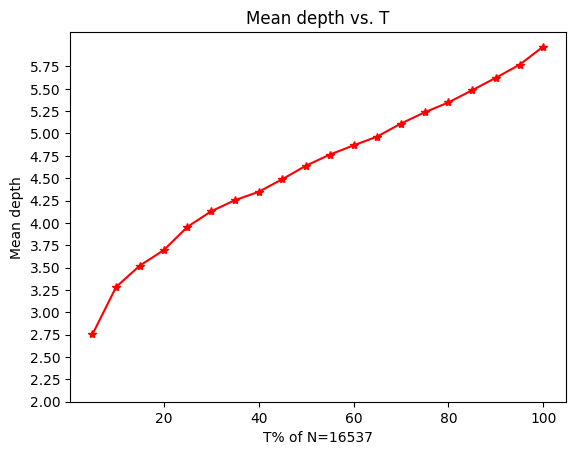

In [18]:
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol

# Array sumas acumuladas de contProfundidades

accumDepth = np.array([0]*(MAXDEPTH+2))
accumHojas = np.array([0]*(MAXDEPTH+2))
for i in range(1,MAXDEPTH+2):
    accumDepth[i] = accumDepth[i-1] + contProfundidades[i-1]
    accumHojas[i] = accumHojas[i-1] + contHojas[i-1]

print("Depths:", contProfundidades)
print(accumDepth)

print("Leafs:", contHojas)
print(accumHojas)

step = 5
nsteps = 100//step
meanDepth = [0] * nsteps

for j in range(0, nsteps):
    sum = 0
    T = (j+1)*step/100
    acum = 0
    i = 0
    k = 0
    while acum < T*N:
        if acum + contProfundidades[i] > T*N:
            k = T*N - acum
            sum = sum + k*i
            acum = T*N
        else:
            sum = sum + contProfundidades[i]*i
            acum = acum + contProfundidades[i]
        i = i + 1
        
    #print("T = ", T, " profundidad media total = ", sum/(T*N))
    meanDepth[j] = sum/(T*N)

# 6. Plot de dispersión de la profundidad media vs. T

import matplotlib.pyplot as plt
import numpy as np

T = np.arange(step,100+step,step)
plt.plot(T, meanDepth, 'r')
plt.plot(T, meanDepth, 'r*')
plt.xlabel(f'T% of N={N}')
plt.ylabel('Mean depth')
plt.yticks(np.arange(int(meanDepth[0]), int(meanDepth[-1])+1, 0.25))
plt.title('Mean depth vs. T')
plt.show()

# Save mean depth
df = pd.DataFrame({'T': T, 'Mean depth': meanDepth})
df.to_csv(rDir + '/mean_depth.csv', index=False)


## 2. Selección de nodos
Vamos a contar cuántos nodos son escogidos a cada profundidad. Se escogen los nodos hoja del árbol cortado a profundidad $d$.

Para cada profundidad $d$ se toman todos los nodos hoja del subárbol que tiene todos los nodos de profundidad $\le d.$ Esto "cubre" intuitivamente el 100% de la ontología. Todo nodo a profundidad mayor que $d$ tiene un único ascendiente en el conjunto de nodos escogidos.

[1, 23, 155, 828, 2503, 5333, 7742, 9501, 10470, 10813, 11012, 11061, 11077, 11083, 11084]


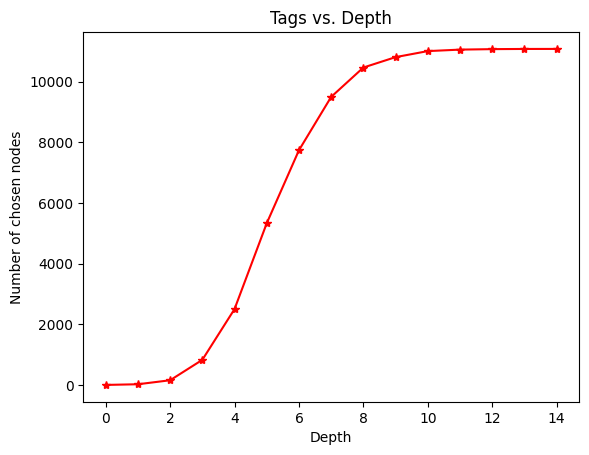

In [19]:
# 7. Plot Nº nodos escogidos vs Profundidad d

# chosen nodes = nodos hoja del subárbol con profundidad d
y = [0]*(MAXDEPTH+1)
z = [0]*(MAXDEPTH+1)
for i in range(MAXDEPTH+1):
    y[i] = contProfundidades[i] + accumHojas[i]

print(y)

plt.plot(range(MAXDEPTH+1), y, 'r')
plt.plot(range(MAXDEPTH+1), y, 'r*')

plt.xlabel('Depth')
plt.ylabel('Number of chosen nodes')
plt.title('Tags vs. Depth')
plt.show()


* Tabla chosen nodes vs depth: coverpercent es el porcentaje de nodos a profundidad <= d

In [20]:
# Save depth count
dfDepth = pd.DataFrame({'depth': range(MAXDEPTH+1), 'count': contProfundidades, 'leafs': contHojas, 'subtree':accumDepth[1:],'chosen': y})
dfDepth['out'] = N - dfDepth['subtree']
dfDepth['coverPercent'] = dfDepth['subtree']/N * 100
dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')
display(dfDepth)

,depth,count,leafs,subtree,chosen,out,coverPercent
0,0,1,0,1,1,16536,0.006047
1,1,23,0,24,23,16513,0.145129
2,2,155,28,179,155,16358,1.082421
3,3,800,318,979,828,15558,5.920058
4,4,2157,1198,3136,2503,13401,18.963536
5,5,3789,2502,6925,5333,9612,41.875794
6,6,3696,2569,10621,7742,5916,64.225676
7,7,2886,1985,13507,9501,3030,81.677451
8,8,1870,1535,15377,10470,1160,92.985427
9,9,678,543,16055,10813,482,97.085324


Si quisiéramos no coger todos los nodos del corte a profundidad $d$ sino una muestra no estaríamos cubriendo el 100% de la ontología. ¿Cuánto estaríamos cubriendo? Pues depende de cómo midas el "tamaño" de cada nodo en la ontología. ¿Tienen todos los nodos el mismo tamaño? Entonces solo importaría el número de descendientes de los nodos que se dejan fuera de la muestra. Creo que convendría más medirlo por el IC, pero es complicar la cosa. ¿Cómo se calcula el IC de un conjunto de nodos? Si lo supiera pondría:
$$ \%cubierto = \frac{IC(muestra)} {IC(elegidos)} $$
Una alternativa sería considerando que los nodos más importantes son los que más nodos tienen por debajo:
$$ \%cubierto = \frac{Tam(muestra)} {Tam(elegidos)}$$
donde $Tam(N)$ se refiere al tamaño del subárbol del nodo $N$.

Text(0, 0.5, '% Cubierto')

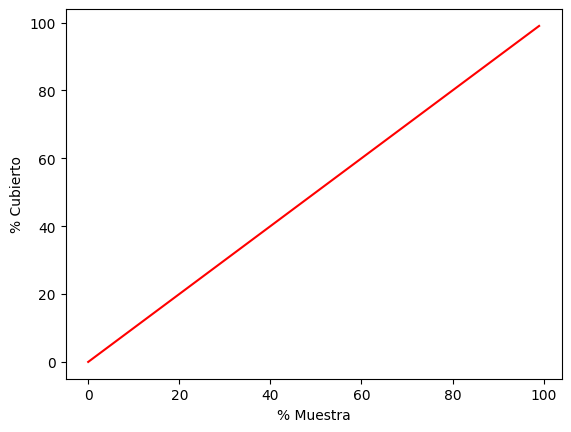

In [23]:
plt.plot(range(100),range(100),'r')
plt.xlabel('% Muestra')
plt.ylabel('% Cubierto')